In [16]:
import pathlib
import imageio
import numpy as np


#THIS FUNCTION CREATES THE FULL MASKS IN THE DATA - USE ONLY ONCE, IT IS LONG.

folders = []

p = pathlib.Path("DATA/train/")

#Looking for all the folders existing in train folder
for i in p.glob('*'):
    
    path = "DATA/train/"
    path += i.name;
    
    f_path = pathlib.Path(path)
    folders.append(f_path)


for p in folders:
    
    mask_name = str(p)
    mask_name+= "/images/mask.png"
    ma_p = str(p)
    ma_p += "/masks/"
    
    #First, we set the paths for the full mask and the sub-masks

    ma_path = pathlib.Path(ma_p)


    
    masks = []
    #Then, we read every sub mask
    maskp = ma_p
    for i in ma_path.glob('*.png'):
        name =""
        name = i.name
        ma_p = maskp
        ma_p += name
        sub_mask = imageio.imread(ma_p)
        masks.append(sub_mask)
    
    mask = masks[0]
    for m in masks: 
        mask = np.where((mask + m) > 200, 255, 0)
        #Finaly, we regroup every sub mask in a single one.

        
    #We add the mask to the image folder   
    imageio.imwrite(mask_name,mask)


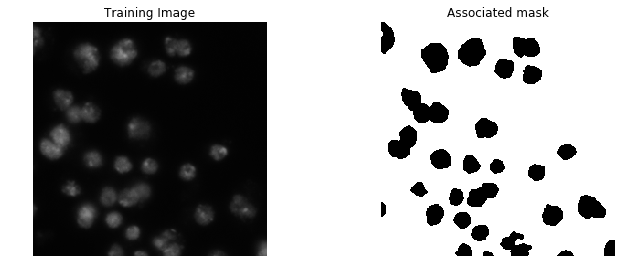

In [19]:
import pathlib
import imageio
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt


folders = []
training_set = dict()
idx = 0

p = pathlib.Path("DATA/train/")

#Looking for all the folders existing in train folder
for i in p.glob('*'):
    
    path = "DATA/train/"
    path += i.name;
    
    f_path = pathlib.Path(path)
    folders.append(f_path)


for p in folders:
    
    im_p = str(p)
    im_p += "/images/"
    
    #First, we set the paths for the image and the masks

    im_path = pathlib.Path(im_p)
    ma_path = pathlib.Path(ma_p)

    
    #Then, we read the image
    name =""
    for i in im_path.glob('*.png'):
        name = i.name
        if name == "mask.png":
            mask_path = im_p + name
            mask = imageio.imread(mask_path)
        else:
            image_path = im_p + name
            im = imageio.imread(image_path)
    

    
    training_set[idx] = (im, mask)
    idx += 1

    
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(training_set[0][0])
plt.axis('off')
plt.title('Training Image')

plt.subplot(1,2,2)
plt.imshow(training_set[0][1], cmap='binary')
plt.axis('off')
plt.title('Associated mask')

plt.tight_layout()
plt.show()




In [125]:
import pathlib
import imageio
import numpy as np
import time
import pandas as pd

# Glob the training data and load a single image path
training_paths = pathlib.Path('DATA/train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])

im_path = training_sorted[129]
im = imageio.imread(str(im_path))

In [33]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))



Original image shape: (256, 320, 4)
New image shape: (256, 320)


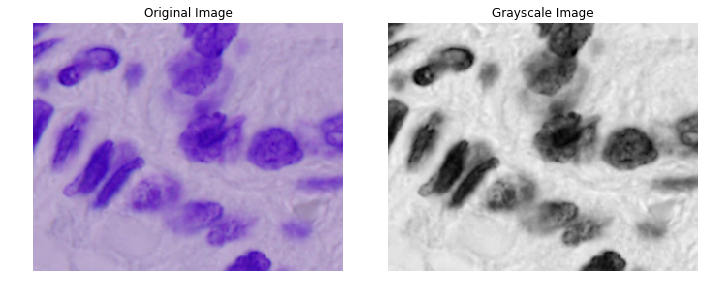

In [34]:
# Now, let's plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

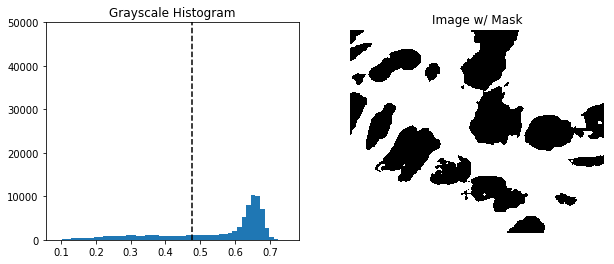

In [35]:
from skimage.filters import threshold_otsu


thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

    
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
#plt.imshow(im_gray, cmap='gray')
plt.imshow(mask, cmap='binary', alpha=1)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()


In [36]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 19 separate components / objects detected.


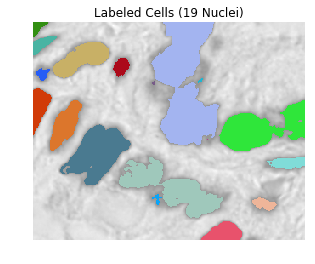

In [37]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [38]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 50: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 6 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 12 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
There are now 15 separate components / objects detected.


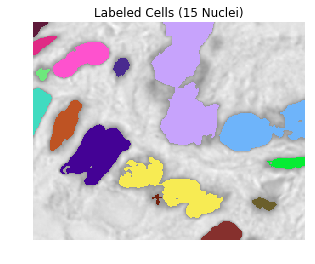

In [39]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

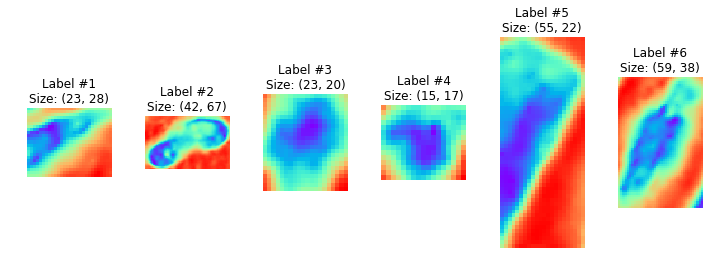

In [47]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[2:8]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='rainbow')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()